##     **ResNet Model**

In [ ]:
# Connect to google drive files
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/homework_1/

# Import libraries and dependecies

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
from collections import defaultdict

import logging

import random

# Import tensorflow
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow_datasets as tfds
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print(tf.__version__)

# Import other libraries
import cv2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


# Install keras-cv
!pip install keras-cv
import keras_cv
from keras_cv import layers as kcvl

# Setting seed
seed = 203
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)




Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/homework_1
2.14.0


In [ ]:
#-------------------------------------------
#      IMAGE PROCESSING AND IMPORT
#-------------------------------------------

def setup(filename, unzip= False):

  # Unzip the '.zip' file if the 'unzip' flag is True
  if unzip:
      !unzip "$filename".zip

  dataset = np.load(filename+'.npz', allow_pickle=True)
  data = dataset['data']
  labels = dataset['labels']

  # Normalize the image pixel values to a float range
  for img in range(data.shape[0]):
    data[img] = (data[img] / 255).astype(np.float32)

  print("Original size of data:", data.shape)
  print("Original size of labels:", labels.shape)

  return data, labels


data,labels = setup('public_data')

# Count how many instances of each class there are
unique, count = np.unique(labels, return_counts = True)
print('Target labels:', unique)
for u in range(len(unique)):
    print(f'Class {unique[u]} has {count[u]} samples')

# Convert labels to one-hot encoding format
print("The first 10 labels are:")
print(labels[:10])
labels = pd.get_dummies(labels).to_numpy().astype(np.float32)
print("Converted into:")
print(labels[:10])


Original size of data: (5200, 96, 96, 3)
Original size of labels: (5200,)
Target labels: ['healthy' 'unhealthy']
Class healthy has 3199 samples
Class unhealthy has 2001 samples
The first 10 labels are:
['healthy' 'healthy' 'healthy' 'unhealthy' 'unhealthy' 'healthy'
 'unhealthy' 'healthy' 'healthy' 'healthy']
Converted into:
[[1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


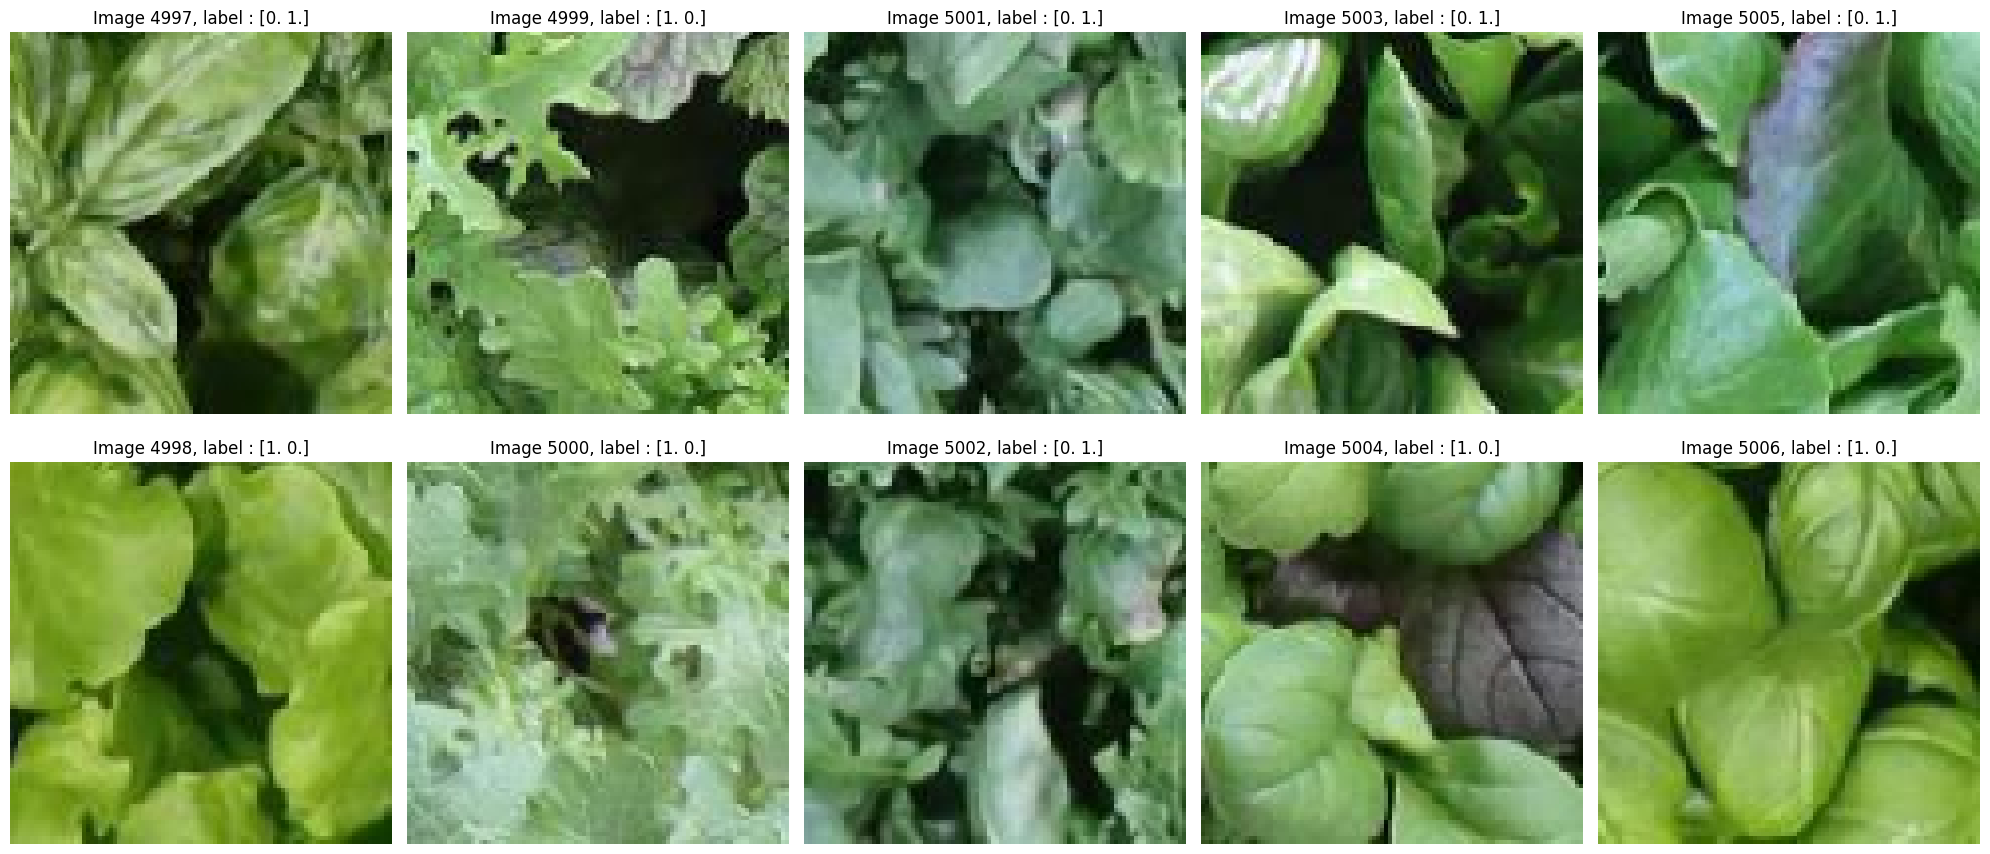

In [ ]:
#-----------------------------
#       DATA INSPECTION
#-----------------------------



# Plot some pictures form the dataset
# Number of images to display
num_img = 10
random_offset = np.random.randint(5089)

# Create subplots to display data
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(data[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {labels[i+random_offset]}')
plt.tight_layout()
plt.show()


In [ ]:

#----------------------------------------------------------------------------------------
#
#                                - DATA CLEAN-UP UTILS -
#
#----------------------------------------------------------------------------------------


# Remove multiple instances of the same images (Shrek and trololo "outliers")

# Hash of an image:
def dhash(image, hash_size=8):
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    diff = resized[:, 1:] > resized[:, :-1]
    return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

# Find duplicates in the data
def clean_data(data, labels, delete = True):

    print("Cleaning data...")

    image_hashes = {} # Dictionary for unique images
    duplicates = [] # List of duplicated images

    new_data = []  # Initialize a list for unique images
    new_labels = []  # Initialize a list for unique labels

    for i, image in enumerate(data):
        h = dhash(image)
        if h in image_hashes:
            duplicates.append((i, image_hashes[h], image, np.argmax(labels[i])))
        else:
            image_hashes[h] = i
            #print("Image:",i,"- Label:", labels[i])
            new_data.append(image)
            new_labels.append(labels[i])


    # Count duplicates with different labels and different image hashes
    duplicate_counts = defaultdict(lambda: defaultdict(int))

    for i, (_,hash_value,_,label) in enumerate(duplicates):
      duplicate_counts[hash_value][label] += 1

    for hash_value, label_counts in duplicate_counts.items():
      for label, count in label_counts.items():
        # Print the most relevant counts for the duplicates
        if count > 5:
          print(f"Image Hash: {hash_value}")
          print(f"  Label: {label}, Duplicates count: {count}")
          # Delete the original copy of data
          if delete == True:
            # Get the hash of the orginal (first)image
            h_0 = dhash(data[hash_value])
            # Loop over the new_data list and search for the original image
            for i, image in enumerate(new_data):
              h = dhash(image)
              # Once found, remove it...
              if h == h_0:
                new_data.pop(i)
                new_labels.pop(i)

        elif delete == False:
          for i in range(count):
            new_data.append(data[hash_value])
            new_labels.append(labels[hash_value])


    new_data = np.array(new_data)
    new_labels = np.array(new_labels)


    print("The total number of duplicates is :", len(duplicates))


    print('Data cleaned!')

    return new_data, new_labels, duplicates, image_hashes

# A custom defined function to check on the correctness of the data
def check_correctness(data,label, cleaned_data, cleaned_label, image_hashes):
  count = 0
  #For each element in the cleaned data array, compute the hash function
  for i, image1 in enumerate(cleaned_data):
    h1 = dhash(image1)
    # Fetch the index of the corresponding image in the original dataset
    j = image_hashes[h1]
    h2 = dhash(data[j])
    if h1 == h2:
      if not (np.array_equal(cleaned_label[i],label[j])):
        count+= 1
    else:
      print("Somthing went wrong in the cleaning of the data...")
  print("Total number of inconsistent data is:", count)
  return

#----------------------------------------------------------------------------------------
# Clean the data
data_new,labels_new,duplicates,valid_images = clean_data(data,labels, True)
# Check for correctness of data cleaning
check_correctness(data, labels, data_new, labels_new, valid_images)

#----------------------------------------------------------------------------------------
#
#                                -  DATA AUGMENTATION -
#
#----------------------------------------------------------------------------------------

augmenter = tf.keras.Sequential([


  # #RANDOM ROTATION
  tf.keras.layers.RandomRotation(factor=(-0.4, 0.4)),
  # #RANDOM CROP
  #    tfkl.RandomCrop(96,96),
  # #TRANSLATION
  #  tfkl.RandomTranslation(0.1,0.1, fill_mode = 'reflect'),
  # #BRIGHTNESS
  # tfkl.RandomBrightness(0.3, value_range=(0,1)),
  # #CONTRAST
  # tfkl.RandomContrast(-0.08),
  # #FLIP
    tfkl.RandomFlip(mode="horizontal_and_vertical"),
  # # RANDOM ZOOM
  #tfkl.RandomZoom(0.1, fill_mode = 'nearest'),
  # # GAUSSIAN NOISE
  tfkl.GaussianNoise(0.1),


  ], name='Preprocessing')

def preprocess_data(images, labels, augment=False):
    inputs =  images
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs, labels

#----------------------------------------------------------------------------------------

augment =True



Cleaning data...
Image Hash: 58
  Label: 1, Duplicates count: 97
Image Hash: 338
  Label: 0, Duplicates count: 97
The total number of duplicates is : 348
Data cleaned!
Total number of inconsistent data is: 0


The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_unhealty <-- dataset are: 1064


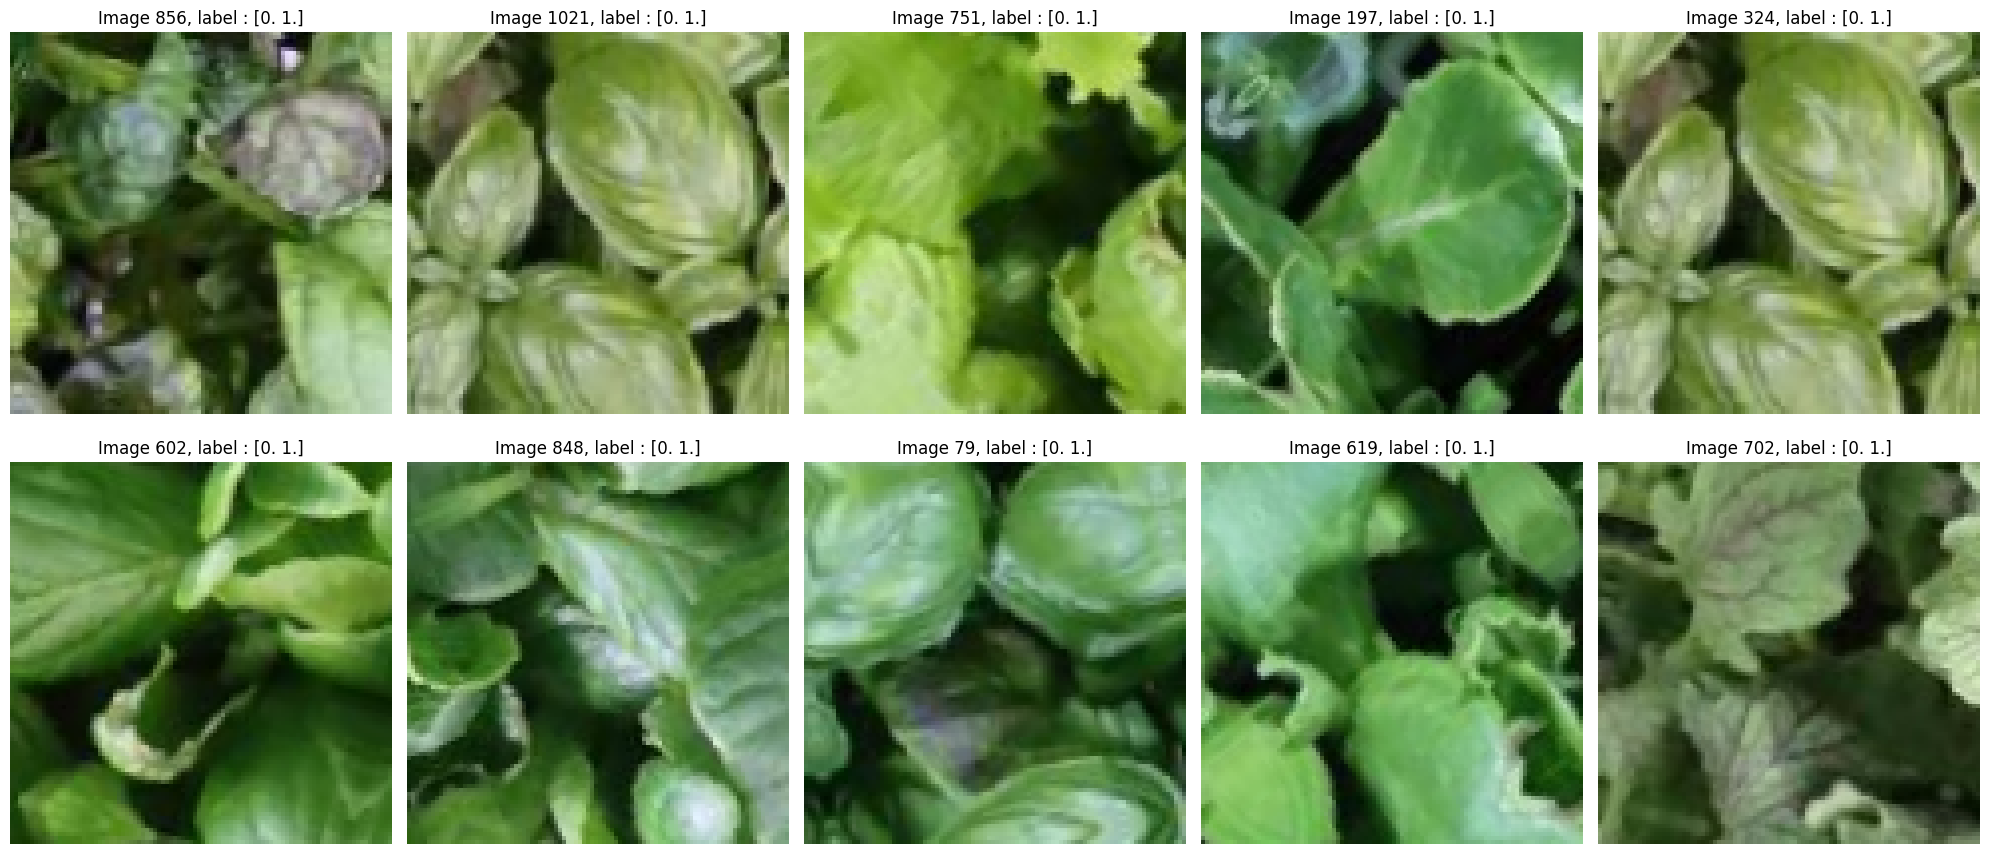

In [ ]:

X_train, X_val, y_train, y_val = train_test_split(data_new, labels_new, test_size=0.15, stratify=np.argmax(labels_new,axis=1))

# Store the original dataset somewhere else
X_train0 = X_train
X_val0 = X_val
y_train0 = y_train
y_val0  = y_val


#------------------------------------------
#              OVERSAMPLING

sampling_augmentation = True

if sampling_augmentation:
    UNHEALTY_PERCENTAGE = 0.7
    #
    # First get the indices for healty and unhealty data
    healty = y_train[:,0] == 1.0
    unhealty = y_train[:,1] == 1.0

    # Perform oversampling using Mixcut primarly on the unhealty dataset

    X_unhealty = X_train[unhealty]
    y_unhealty = y_train[unhealty]

    # Modify the seed to modify the randomization of MixCut filter
    seed = 59

    X_unhealty, y_unhealty = preprocess_data(X_unhealty, y_unhealty, augment)

    X_unhealty = X_unhealty.numpy()

    # Shuffle the augmented data
    perm_unhealty = np.random.permutation(len(X_unhealty))

    X_unhealty = X_unhealty[perm_unhealty]

    # Keep a certain percentage of the data to be inserted in the new dataset
    X_unhealty = X_unhealty[:int(len(X_unhealty)*UNHEALTY_PERCENTAGE)]
    y_unhealty = y_unhealty[:int(len(y_unhealty)*UNHEALTY_PERCENTAGE)]

    print("The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_unhealty <-- dataset are:", sum(y_unhealty[:, 1] == 1.))


    # Create subplots to display data
    fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
    for i in range(num_img):
        ax = axes[i%2, i%num_img//2]
        ax.imshow(np.clip(X_unhealty[i+ np.random.randint(len(X_unhealty)-10)], 0, 255))  # Display clipped item images
        ax.axis('off')
        ax.set_title(f'Image {i+ np.random.randint(len(X_unhealty)-10)}, label : {y_unhealty[i+np.random.randint(len(X_unhealty)-10)]}')
    plt.tight_layout()
    plt.show()

#------------------------------------------

In [ ]:

#-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
#                         DATA AUGMENTATION
#---------------------------------------------------------------------
# Redefine augementer for a second augmentation
augmenter = keras_cv.layers.Augmenter(
    [
        # keras_cv.layers.RandAugment(
        #     value_range=(0., 1.),
        #     augmentations_per_image=2,
        #     magnitude=0.2,
        #     magnitude_stddev=0.2,
        #     rate=0.4,
        # ),
        #keras_cv.layers.CutMix(seed = seed),
        keras_cv.layers.MixUp( seed = seed, alpha = 0.6),
        #keras_cv.layers.RandomCutout(0.3, 0.3),
        #keras_cv.layers.RandomHue(0.1, [0, 1]),

    ],
)

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']


augment = True

# Apply eventual augmentation (if augment == False, this function does nothing)
X_train, y_train = preprocess_data(X_train, y_train, augment)

if augment:
  X_train = X_train.numpy()
  y_train = y_train.numpy()
  # Merge the data...
  X_train = np.concatenate((X_train, X_train0))
  y_train = np.concatenate((y_train, y_train0))

if sampling_augmentation:
  # Merge with unhealty artifical data
  X_train = np.concatenate((X_train, X_unhealty))
  y_train = np.concatenate((y_train, y_unhealty))

# And shuffle them
perm = np.random.permutation(len(X_train))
X_train = X_train[perm]
y_train = y_train[perm]



# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print("The total number of PURE -> HEALTY <- SAMPLES in the  --> X_train <-- dataset are:", sum(y_train[:, 0] == 1.))
print("The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_train <-- dataset are:", sum(y_train[:, 1] == 1.))
print("The total number of PURE -> HEALTY SAMPLES <- in the  --> X_val <-- dataset are:", sum(y_val[:, 0] == 1.))
print("The total number of PURE -> UNHEALTY SAMPLES <- in the  --> X_val <-- dataset are:", sum(y_val[:, 1] == 1.))

X_train shape: (9308, 96, 96, 3), y_train shape: (9308, 2)
X_val shape: (728, 96, 96, 3), y_val shape: (728, 2)
The total number of PURE -> HEALTY <- SAMPLES in the  --> X_train <-- dataset are: 4246
The total number of PURE -> UNHEALTY <- SAMPLES in the  --> X_train <-- dataset are: 3150
The total number of PURE -> HEALTY SAMPLES <- in the  --> X_val <-- dataset are: 459
The total number of PURE -> UNHEALTY SAMPLES <- in the  --> X_val <-- dataset are: 269



Here are the cleaned images...



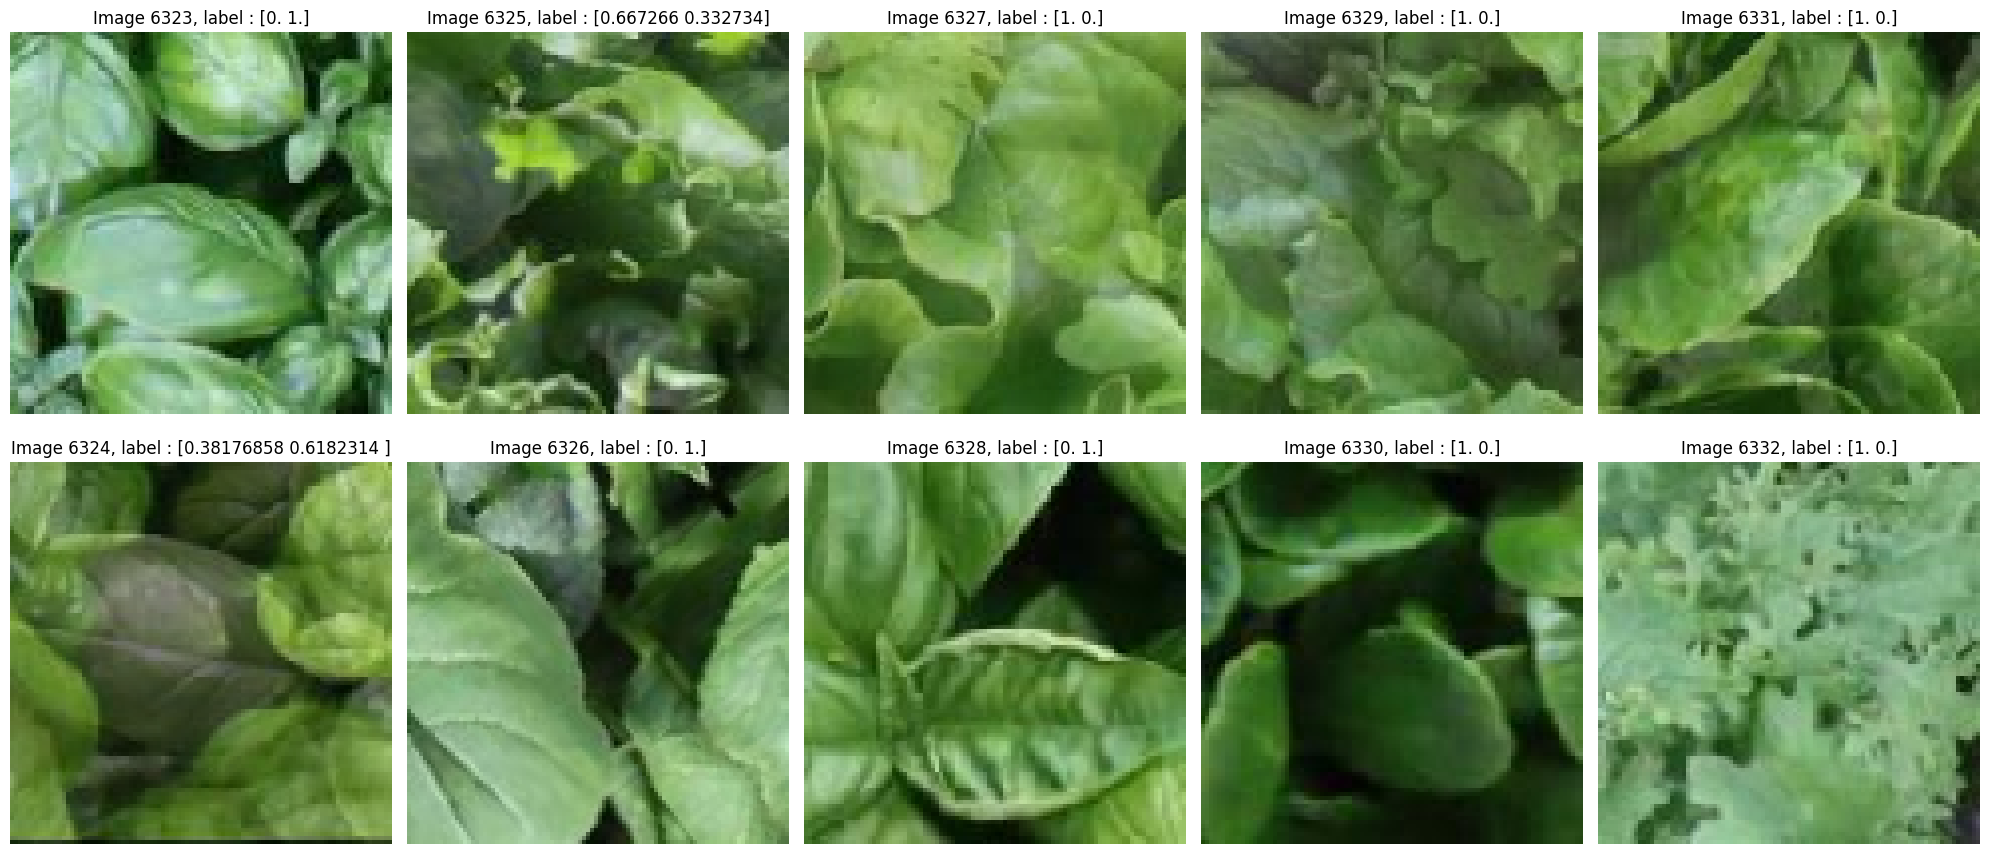

In [ ]:
num_img  = 10
random_offset = random_offset = np.random.randint(len(X_train)-10)


print('\nHere are the cleaned images...\n')
# Create subplots to display data (cleaned)
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(X_train[i+ random_offset], 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {y_train[i + random_offset]}')
plt.tight_layout()
plt.show()





Here are the cleaned (and augmented) images...



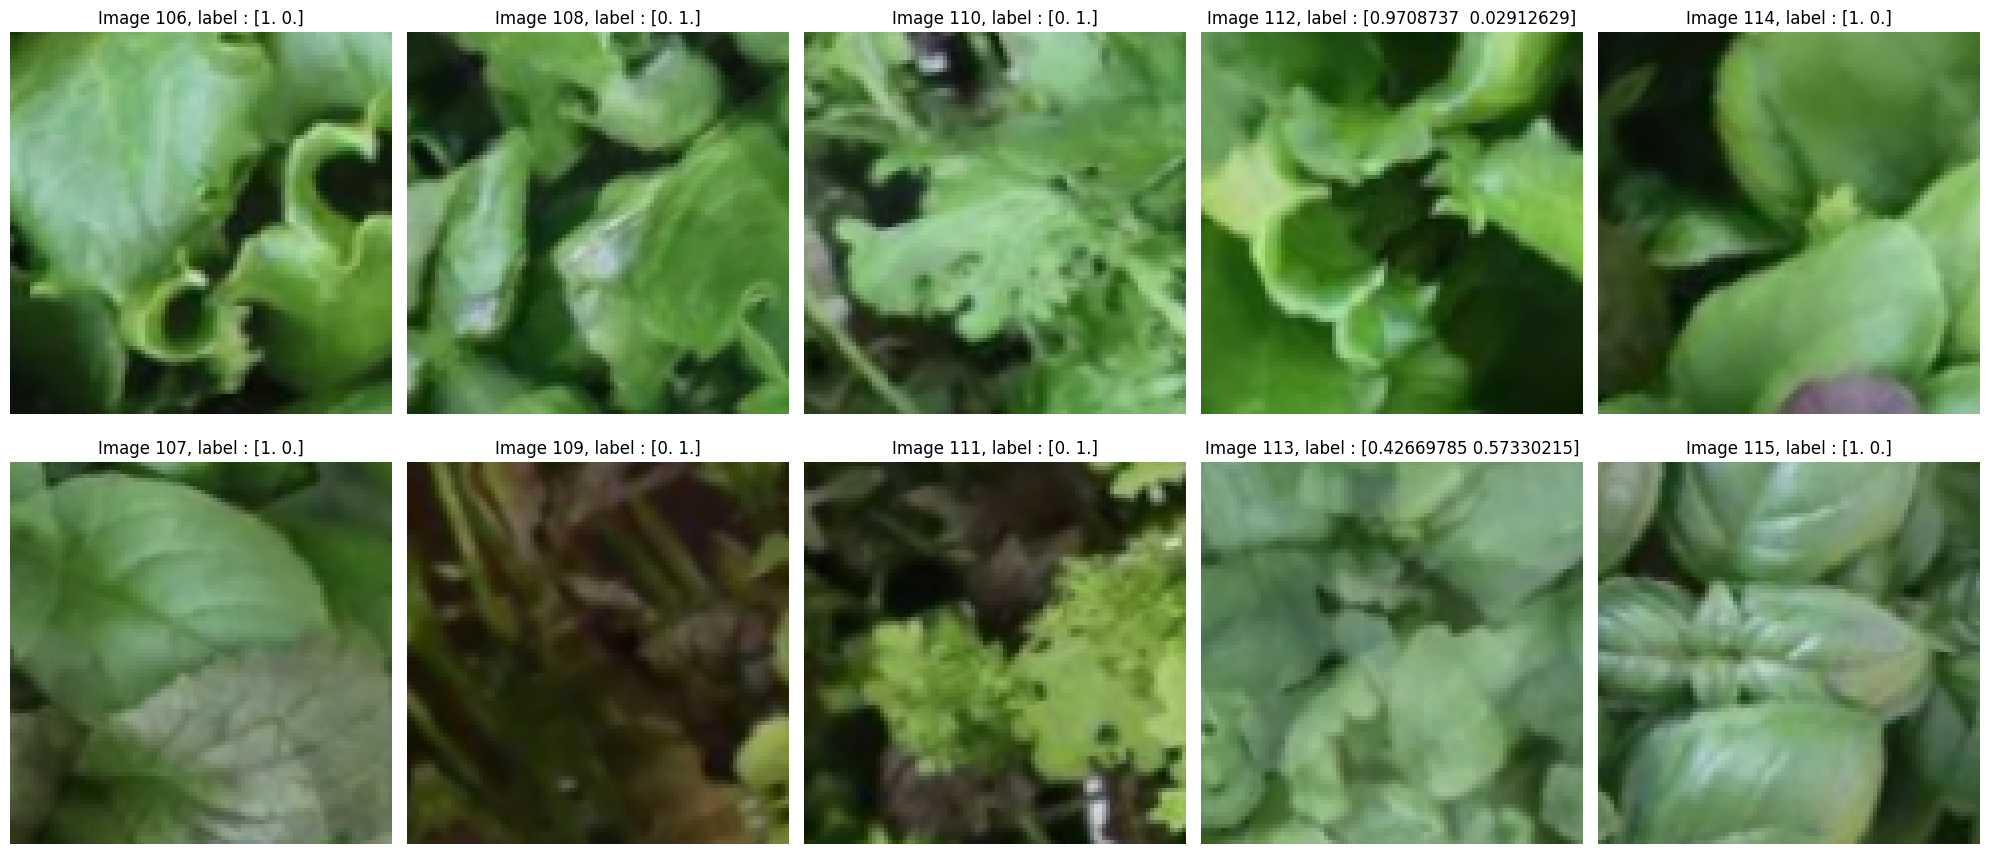

In [ ]:



preprocessing = tf.keras.Sequential([

  # #RANDOM ROTATION
  tf.keras.layers.RandomRotation(factor=(-0.4, 0.4)),
  # #TRANSLATION
  # tfkl.RandomTranslation(0.15,0.15, fill_mode = 'reflect'),
  # #BRIGHTNESS
  # tfkl.RandomBrightness(0.3, value_range=(0,1)),
  # #CONTRAST
  #  tfkl.RandomContrast(0.5),
  # #FLIP
    tfkl.RandomFlip(mode="horizontal_and_vertical"),
  # # RANDOM ZOOM
  tfkl.RandomZoom((-0.05,-0.12), (-0.05,-0.12), fill_mode = 'nearest'),
  # #RANDOM CROP
  #   tfkl.RandomCrop(96,96),

  ], name='Preprocessing')


#->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-




num_img  = 10
random_offset = random_offset = np.random.randint(4000 - len(duplicates))


print('\nHere are the cleaned (and augmented) images...\n')
# Create subplots to display data (cleaned)
fig, axes = plt.subplots(2, num_img//2, figsize=(20, 9))
for i in range(num_img):
    ax = axes[i%2, i%num_img//2]
    ax.imshow(np.clip(preprocessing(X_train[i+ random_offset]), 0, 255))  # Display clipped item images
    ax.axis('off')
    ax.set_title(f'Image {i+ random_offset}, label : {y_train[i + random_offset]}')
plt.tight_layout()
plt.show()


In [ ]:

# Define some handy global variables
BATCH_SIZE = 64
EPOCHS = 200


# --------------------------------------------------------------------
#                           LR SCHEDULER
# --------------------------------------------------------------------

def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

# Define callback for learning rate scheduler and warmup

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = model.optimizer.lr.numpy()
        self.lrs.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        tfk.backend.set_value(self.model.optimizer.lr, lr)



total_steps = len(X_train)/BATCH_SIZE *EPOCHS

warmup_steps = int(0.03*total_steps)



# --------------------------------------------------------------------

In [ ]:



def build_model_ResNet(dropout_rate = 1/4, imagenet = True, weight_decay = True, weight_factor = 5e-4,print_flag = True):



  #-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
  #                          RESNET LOADING
  #---------------------------------------------------------------------
  # Create ResNet50V2 model with specified settings
  # i.e. import FE part
  if imagenet:
    resnet = tfk.applications.ResNet50V2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights = 'imagenet',
        pooling='max',
    )
  else:
    resnet = tfk.applications.ResNet50V2(
        input_shape=(96, 96, 3),
        include_top=False,
        weights = None,
        pooling='max',
    )


  #->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->->-


  #-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-<-
  #                         FC DEFINITION (custom)
  #---------------------------------------------------------------------

  x_input = tfk.Input(shape=(2048,), name="last_input")

  x3 =tfkl.Dense(units=128, kernel_initializer='he_uniform',name='DenseLast3')(x_input)
  x =tfkl.BatchNormalization(name='BatchNormLast3')(x3)
  x =tfkl.Activation('gelu', name='ActivationLast3')(x)
  x = tfkl.Dropout(dropout_rate,name = 'Dropout3')(x)

  x4 =tfkl.Dense(units=128, kernel_initializer='he_uniform',name='DenseLast4')(x)
  x = tfkl.Add()([x3,x4])
  x =tfkl.BatchNormalization(name='BatchNormLast4')(x)
  x =tfkl.Activation('gelu', name='ActivationLast4')(x)
  x =tfkl.Dropout(dropout_rate, name = 'DropOut4')(x)


  x1 =tfkl.Dense(units=32, kernel_initializer='he_uniform',name='DenseLast5')(x)
  x =tfkl.BatchNormalization(name='BatchNormLast5')(x1)
  x =tfkl.Activation('gelu', name='ActivationLast5')(x)
  x =tfkl.Dropout(0.2, name = 'DropOut5')(x)

  x2 =tfkl.Dense(units=32, kernel_initializer='he_uniform',name='DenseLast6')(x)
  x = tfkl.Add()([x1,x2])
  x =tfkl.BatchNormalization(name='BatchNormLast6')(x)
  x =tfkl.Activation('gelu', name='ActivationLast6')(x)
  x_output =tfkl.Dropout(0.2, name = 'DropOut6')(x)


  last = tfk.Model(x_input, x_output, name="lastClassifier")

  #---------------------------------------
  #---------------------------------------

  # Create an input layer with shape (96, 96, 3)
  inputs = tfk.Input(shape=(96, 96, 3), name = 'Input')


  preprocessing = tf.keras.Sequential([
  # #RANDOM ROTATION
  tf.keras.layers.RandomRotation(factor=(-0.4, 0.4)),
  # #TRANSLATION
  # tfkl.RandomTranslation(0.15,0.15, fill_mode = 'reflect'),
  # #BRIGHTNESS
  # tfkl.RandomBrightness(0.3, value_range=(0,1)),
  # #CONTRAST
  #  tfkl.RandomContrast(0.5),
  # #FLIP
    tfkl.RandomFlip(mode="horizontal_and_vertical"),
  # # RANDOM ZOOM
  tfkl.RandomZoom((-0.05,-0.15), (-0.05,-0.15), fill_mode = 'nearest'),
  # #RANDOM CROP
  #   tfkl.RandomCrop(96,96),

  ], name='Preprocessing')

  # Connect preprocessing layer to input
  preprocess = preprocessing(inputs)

  # Connect ResNet50V2 to the preprocessing layer

  #---------------------------------------
  #         FE and FC CONJUNCTION
  #---------------------------------------

  layer_name = 'conv5_block3_out'
  base = tfk.Model(inputs=resnet.inputs, outputs=resnet.get_layer(layer_name).output, name = 'resnet50v2')

  x = base(preprocess)

  # Add a Global Average Pooling layer to implement independece form translation

  x_avg = tfkl.GlobalAveragePooling2D(name='GlobalAveragePooling')(x)

  #-----------------------------------

  last = last(x_avg)

  # Add a Dense layer with 2 units and softmax activation as the classifier
  x = tfkl.Dense(units= 2, name = 'DenseOutput')(last)
  outputs = tfkl.Activation('softmax', name='ActivationOutput')(x)

  # Create a Model connecting input and output
  model = tfk.Model(inputs=inputs, outputs=outputs, name='model')


  #-----------------------------------
  #         TRANSFER LEARNING
  #-----------------------------------
  if imagenet == True:

    model.get_layer('resnet50v2').trainable = False

   #-----------------------------------

  if weight_decay:
    optimizer = tfk.optimizers.AdamW(weight_decay = weight_factor)
  else:
    optimizer = tfk.optimizers.Adam()
  loss = tfk.losses.CategoricalCrossentropy()
  metrics = ['accuracy']
  # Compile the model with Categorical Cross-Entropy loss and Adam optimizer
  model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

  # Display model summary

  model.summary()
  if print_flag:
    tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

  return model

In [ ]:
# Create the model...
model = build_model_ResNet(dropout_rate = 0.5, weight_decay = False, print_flag = True)
#tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

94668760/94668760 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 Preprocessing (Sequential)  (None, 96, 96, 3)         0         
                                                                 
 resnet50v2 (Functional)     (None, 3, 3, 2048)        23556608  
                                                                 
 GlobalAveragePooling (Glob  (None, 2048)              0         
 alAveragePooling2D)                                             
                                                                 
 lastClassifier (Functional  (None, 32)                285248    
 )                                                               
                                                              

In [ ]:

# and train it
history = model.fit(
    x = preprocess_input(X_train*255.), # We need to apply the preprocessing thought for the MobileNetV2 network
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (preprocess_input(X_val*255.), y_val),
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=10, min_lr=1e-6, mode='max'),
    WarmupCosineDecay(total_steps=total_steps, warmup_steps=warmup_steps,hold=int(warmup_steps/4),start_lr=0.0, target_lr=5e-4)
    ]
).history

Epoch 1/200
146/146 [==============================] - 27s 76ms/step - loss: 0.8266 - accuracy: 0.5526 - val_loss: 0.6049 - val_accuracy: 0.6566 - lr: 8.3142e-05
Epoch 2/200
146/146 [==============================] - 8s 51ms/step - loss: 0.7091 - accuracy: 0.6107 - val_loss: 0.5523 - val_accuracy: 0.6909 - lr: 1.6686e-04
Epoch 3/200
146/146 [==============================] - 8s 56ms/step - loss: 0.6363 - accuracy: 0.6666 - val_loss: 0.5288 - val_accuracy: 0.7143 - lr: 2.5057e-04
Epoch 4/200
146/146 [==============================] - 7s 51ms/step - loss: 0.5961 - accuracy: 0.6966 - val_loss: 0.5156 - val_accuracy: 0.7198 - lr: 3.3429e-04
Epoch 5/200
146/146 [==============================] - 8s 56ms/step - loss: 0.5672 - accuracy: 0.7205 - val_loss: 0.5181 - val_accuracy: 0.7294 - lr: 4.1800e-04
Epoch 6/200
146/146 [==============================] - 8s 51ms/step - loss: 0.5538 - accuracy: 0.7295 - val_loss: 0.5109 - val_accuracy: 0.7294 - lr: 5.0000e-04
Epoch 7/200
146/146 [============

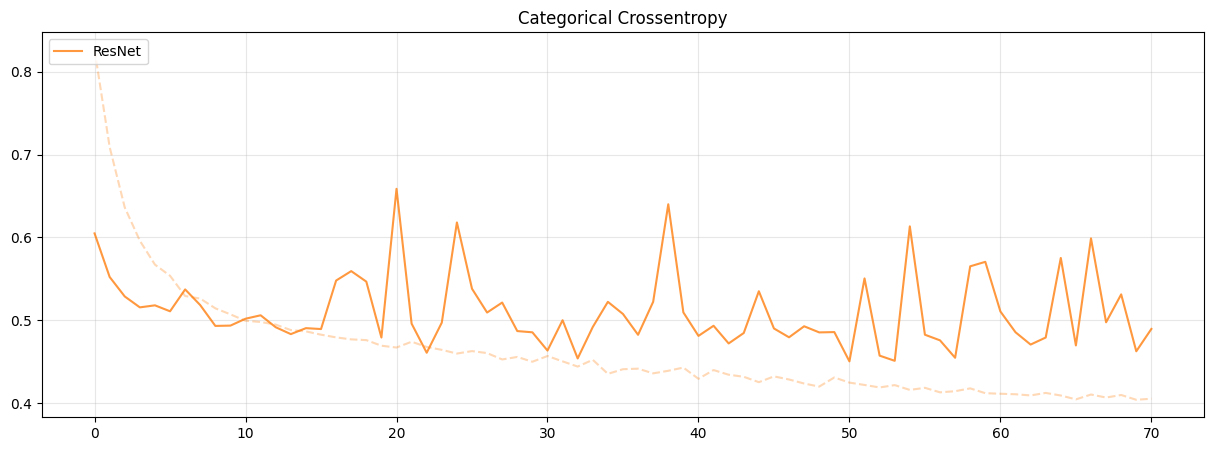

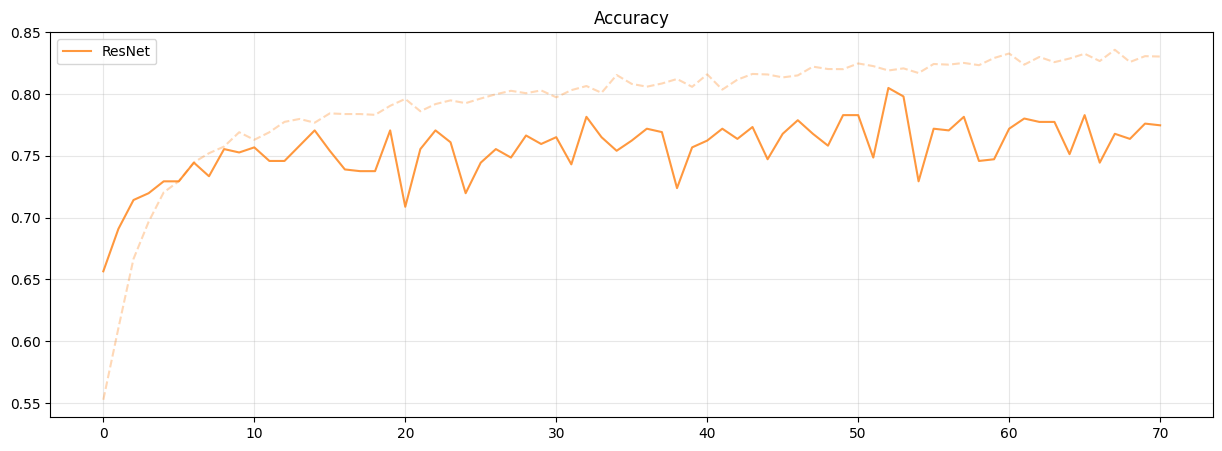

In [ ]:

# Plot the data of the model after the fist step of fine tuning
plt.figure(figsize=(15,5))
plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='ResNet', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='ResNet', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Then save the model for successive tuning
model.save("ResNet/ResNet01")
del model

# ***On the loss plot, the validation trend seems to be more "wobbly" then what we would normally get. We hypothesized this was due to the low representation capability of the validation set, with respect to a much large and artificially augmented dataset***

In [ ]:
#---------------------------------------------------
#             STEP_2 - FINE TUNING
#---------------------------------------------------


X_train = X_train0
y_train = y_train0

# Load the model
model = tfk.models.load_model("ResNet/ResNet01")

# Set all ResNet layers as trainable

model.get_layer('resnet50v2').trainable = True
# Then freeze the last N layers
# N = 154

# for i, layer in enumerate(model.get_layer('resnet50v2').layers[:N]):
#   layer.trainable=False
for i, layer in enumerate(model.get_layer('resnet50v2').layers[:-1]):
  print(i, layer.name, layer.trainable)

#ft_model.summary()



optimizer = tfk.optimizers.Adam()
loss = tfk.losses.CategoricalCrossentropy()
metrics = ['accuracy']

model.compile(loss=loss, optimizer=optimizer, metrics=metrics)


0 input_1 True
1 conv1_pad True
2 conv1_conv True
3 pool1_pad True
4 pool1_pool True
5 conv2_block1_preact_bn True
6 conv2_block1_preact_relu True
7 conv2_block1_1_conv True
8 conv2_block1_1_bn True
9 conv2_block1_1_relu True
10 conv2_block1_2_pad True
11 conv2_block1_2_conv True
12 conv2_block1_2_bn True
13 conv2_block1_2_relu True
14 conv2_block1_0_conv True
15 conv2_block1_3_conv True
16 conv2_block1_out True
17 conv2_block2_preact_bn True
18 conv2_block2_preact_relu True
19 conv2_block2_1_conv True
20 conv2_block2_1_bn True
21 conv2_block2_1_relu True
22 conv2_block2_2_pad True
23 conv2_block2_2_conv True
24 conv2_block2_2_bn True
25 conv2_block2_2_relu True
26 conv2_block2_3_conv True
27 conv2_block2_out True
28 conv2_block3_preact_bn True
29 conv2_block3_preact_relu True
30 conv2_block3_1_conv True
31 conv2_block3_1_bn True
32 conv2_block3_1_relu True
33 conv2_block3_2_pad True
34 conv2_block3_2_conv True
35 conv2_block3_2_bn True
36 conv2_block3_2_relu True
37 max_pooling2d True

In [ ]:


# Train the model
history2 = model.fit(
    x = preprocess_input(X_train*255), # We need to apply the preprocessing thought for the ResNet network
    y = y_train,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (preprocess_input(X_val*255), y_val), # We need to apply the preprocessing thought for the ResNet network
    callbacks=[
    tfk.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
    tfk.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.5, patience=5, min_lr=1e-5, mode='max'),
    WarmupCosineDecay(total_steps=total_steps * 0.7, warmup_steps=warmup_steps,hold=int(warmup_steps/4),start_lr=0.0, target_lr=5e-5)
    ]
).history

Epoch 1/200
65/65 [==============================] - 47s 207ms/step - loss: 0.5868 - accuracy: 0.7154 - val_loss: 0.4935 - val_accuracy: 0.7596 - lr: 3.6697e-06
Epoch 2/200
65/65 [==============================] - 10s 155ms/step - loss: 0.5076 - accuracy: 0.7572 - val_loss: 0.4944 - val_accuracy: 0.7624 - lr: 7.3968e-06
Epoch 3/200
65/65 [==============================] - 10s 152ms/step - loss: 0.4814 - accuracy: 0.7739 - val_loss: 0.4628 - val_accuracy: 0.7885 - lr: 1.1124e-05
Epoch 4/200
65/65 [==============================] - 10s 157ms/step - loss: 0.4490 - accuracy: 0.7923 - val_loss: 0.4562 - val_accuracy: 0.7953 - lr: 1.4851e-05
Epoch 5/200
65/65 [==============================] - 10s 156ms/step - loss: 0.4274 - accuracy: 0.8096 - val_loss: 0.4488 - val_accuracy: 0.8036 - lr: 1.8578e-05
Epoch 6/200
65/65 [==============================] - 10s 153ms/step - loss: 0.4058 - accuracy: 0.8151 - val_loss: 0.4386 - val_accuracy: 0.8077 - lr: 2.2305e-05
Epoch 7/200
65/65 [===============

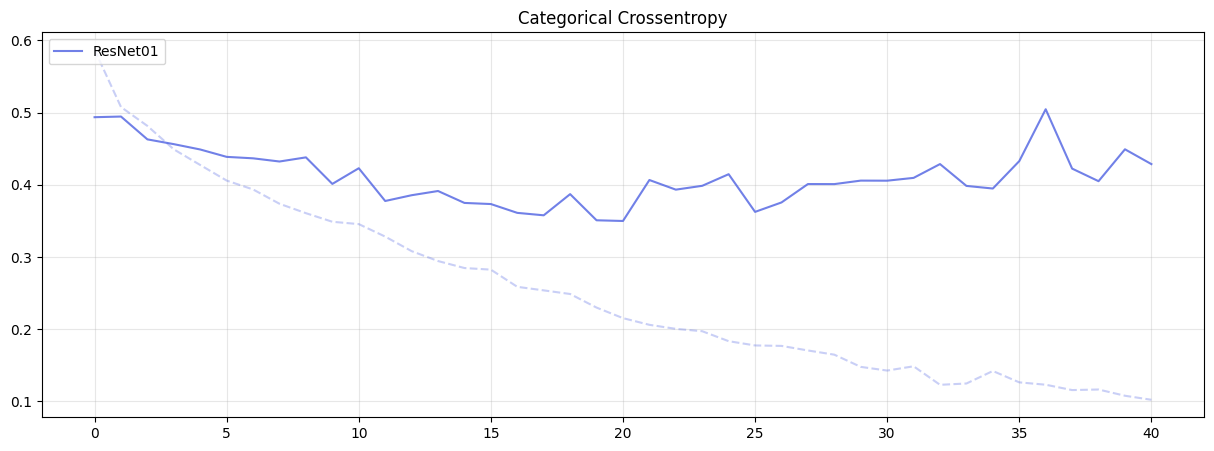

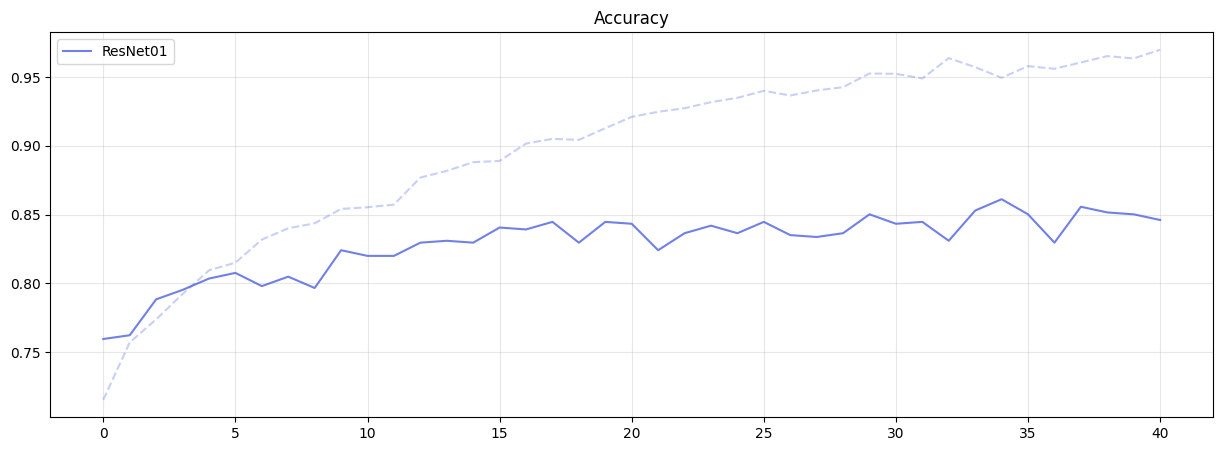

In [ ]:

# Plot the data of the model after the fist step of fine tuning
plt.figure(figsize=(15,5))
# plt.plot(history['loss'], alpha=.3, color='#ff7f0e', linestyle='--')
# plt.plot(history['val_loss'], label='ResNet', alpha=.8, color='#ff7f0e')
plt.plot(history2['loss'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history2['val_loss'], label='ResNet01', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
# plt.plot(history['accuracy'], alpha=.3, color='#ff7f0e', linestyle='--')
# plt.plot(history['val_accuracy'], label='ResNet', alpha=.8, color='#ff7f0e')
plt.plot(history2['accuracy'], alpha=.3, color='#4D61E2', linestyle='--')
plt.plot(history2['val_accuracy'], label='ResNet01', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

# Then save the model for successive tuning
model.save("ResNet/ResNet02")
del model

# ***Here some traces of overfitting are visible, duely stopped using early stopping callback***

In [ ]:
# Quick check on the correctness of output

model = tfk.models.load_model("ResNet/ResNet02")


predictions = model.predict(preprocess_input(X_val*255))  # IMAGES NORMALIZED IN THE RANGE 0,1
test_accuracy = model.evaluate(preprocess_input(X_val*255),y_val,verbose=0)[-1]


print(np.argmax(y_val[:20], axis = 1))
print (tf.argmax(predictions[:20], axis=-1))
print(test_accuracy)

23/23 [==============================] - 2s 29ms/step
[0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 1 0 0 0]
tf.Tensor([0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 0], shape=(20,), dtype=int64)
0.843406617641449


In [ ]:
del model